# LayoutLMv3 Invoice Extraction Inference Notebook

In [1]:
# 1. Import Required Libraries
import os
import random
import json
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import LayoutLMv3ForTokenClassification, LayoutLMv3Processor
from datasets import load_dataset
import torch

# PaddleOCR (GPU) import
from paddleocr import PaddleOCR

# For file selection UI (Jupyter only)
try:
    from ipywidgets import FileUpload, Dropdown, Button, Output, VBox, HBox
    from IPython.display import display, clear_output
    ipywidgets_available = True
except ImportError:
    ipywidgets_available = False

# Utility for field extraction
import re


## 2. Load Trained Model and Processor
Load the trained LayoutLMv3 model and processor for inference. Make sure the model directory exists and contains the necessary files.

In [2]:
# 2. Load Trained Model and Processor
MODEL_DIR = "../backend/models/layoutlmv3-invoice"
assert os.path.exists(MODEL_DIR), f"Model directory not found: {MODEL_DIR}"

processor = LayoutLMv3Processor.from_pretrained(MODEL_DIR)
model = LayoutLMv3ForTokenClassification.from_pretrained(MODEL_DIR)

## Load the pre-trained model and processor from Hugging Face
#model = LayoutLMv3ForTokenClassification.from_pretrained("avurity/layoutlmv3-finetuned-invoice")
#processor = LayoutLMv3Processor.from_pretrained("avurity/layoutlmv3-finetuned-invoice")

model.eval()

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model loaded on device: {device}")

Model loaded on device: cuda


## 3. Select or Randomly Choose an Image for Inference
You can select an image file for inference, or let the notebook randomly pick one from the test set directory.

In [ ]:
# 3. Select or Drag-and-Drop an Image for Inference

import io
from PIL import Image as PILImage

test_img_dir = "../data/invoices-8/test"  # Adjust if your test images are elsewhere
img_extensions = [".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp"]

def list_images(directory):
    return [f for f in os.listdir(directory) if os.path.splitext(f)[1].lower() in img_extensions]

selected_image_filename = None
uploaded_image = None
image_path = None

if ipywidgets_available:
    from ipywidgets import FileUpload, Dropdown, Button, Output, VBox, HBox
    from IPython.display import display, clear_output

    images = list_images(test_img_dir) if os.path.exists(test_img_dir) else []
    dropdown = Dropdown(options=images, description="Test Image:") if images else None
    upload = FileUpload(accept="image/*", multiple=False, description="Drag or Select Image")
    button = Button(description="Load Selected Image")
    out = Output()

    def on_button_clicked(b):
        global selected_image_filename, uploaded_image, image_path
        with out:
            clear_output()
            if upload.value:
                # Use uploaded image (in-memory)
                up = next(iter(upload.value.values())) if isinstance(upload.value, dict) else next(iter(upload.value))
                if isinstance(up, dict) and 'content' in up:
                    uploaded_image = PILImage.open(io.BytesIO(up['content'])).convert("RGB")
                    image_path = None
                    print(f"Using uploaded image: {up.get('metadata', {}).get('name', 'uploaded')}")
                else:
                    print("Upload format not recognized.")
            elif dropdown and dropdown.value:
                selected_image_filename = dropdown.value
                image_path = os.path.join(test_img_dir, selected_image_filename)
                uploaded_image = None
                print(f"Selected: {selected_image_filename}")
            else:
                print("No image selected or uploaded.")

    button.on_click(on_button_clicked)
    widgets = [upload, button, out]
    if dropdown:
        widgets.insert(0, dropdown)
    display(VBox(widgets))
else:
    print("Widget selection unavailable. Use the next cell to pick a random image or select from test set.")

## 4. Run OCR on the Selected Image
Apply PaddleOCR (GPU) to extract words and bounding boxes from the selected image.

In [4]:
# 4. Run OCR on the Selected Image (supports uploaded or file-based image)
from paddleocr import PaddleOCR
import numpy as np

# Ensure OCR is initialized
if 'ocr' not in globals() or ocr is None:
    ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu=False)

if uploaded_image is not None:
    image = uploaded_image
    img_np = np.array(image.convert("RGB"))
    ocr_result = ocr.ocr(img_np, cls=True)
    print("Using uploaded image for inference.")
elif image_path is not None:
    image = Image.open(image_path).convert("RGB")
    ocr_result = ocr.ocr(image_path, cls=True)
    print(f"Using image: {image_path}")
else:
    raise RuntimeError("No image selected or uploaded for inference.")

# Flatten results (PaddleOCR returns a list of lists)
ocr_words = []
ocr_bboxes = []
for line in ocr_result[0]:
    bbox = line[0]
    text = line[1][0]
    ocr_words.append(text)
    # bbox: [[x0, y0], [x1, y1], [x2, y2], [x3, y3]]
    # Convert to [x0, y0, x2, y2] (top-left, bottom-right)
    x0, y0 = bbox[0]
    x2, y2 = bbox[2]
    ocr_bboxes.append([x0, y0, x2, y2])

print(f"Extracted {len(ocr_words)} words from OCR.")

[2025/07/29 07:15:09] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\Haythem/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\Haythem/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text

## 5. Preprocess Image and OCR Output for Model Input
Convert OCR tokens and bounding boxes into the format required by the LayoutLMv3 processor, including normalization and padding.

In [5]:
# 5. Preprocess Image and OCR Output for Model Input
# Use the correct image source (uploaded or file-based)
if uploaded_image is not None:
    image = uploaded_image
elif image_path is not None:
    image = Image.open(image_path).convert("RGB")
else:
    raise RuntimeError("No image selected or uploaded for inference.")

width, height = image.size

# Normalize bboxes to 0-1000 as required by LayoutLMv3
norm_bboxes = []
for bbox in ocr_bboxes:
    x0, y0, x2, y2 = bbox
    x0 = int(1000 * x0 / width)
    y0 = int(1000 * y0 / height)
    x2 = int(1000 * x2 / width)
    y2 = int(1000 * y2 / height)
    norm_bboxes.append([x0, y0, x2, y2])

# Prepare processor input
encoding = processor(
    text=ocr_words,
    boxes=norm_bboxes,
    images=image,
    return_tensors="pt",
    truncation=True,
    padding="max_length",
    max_length=512
)
for k in encoding:
    encoding[k] = encoding[k].to(device)

print(f"Prepared input for model: {len(ocr_words)} tokens, {len(norm_bboxes)} bboxes.")

Prepared input for model: 48 tokens, 48 bboxes.


## 6. Visualize OCR Tokens on the Image
Plot the image with bounding boxes and text for each OCR token using matplotlib.

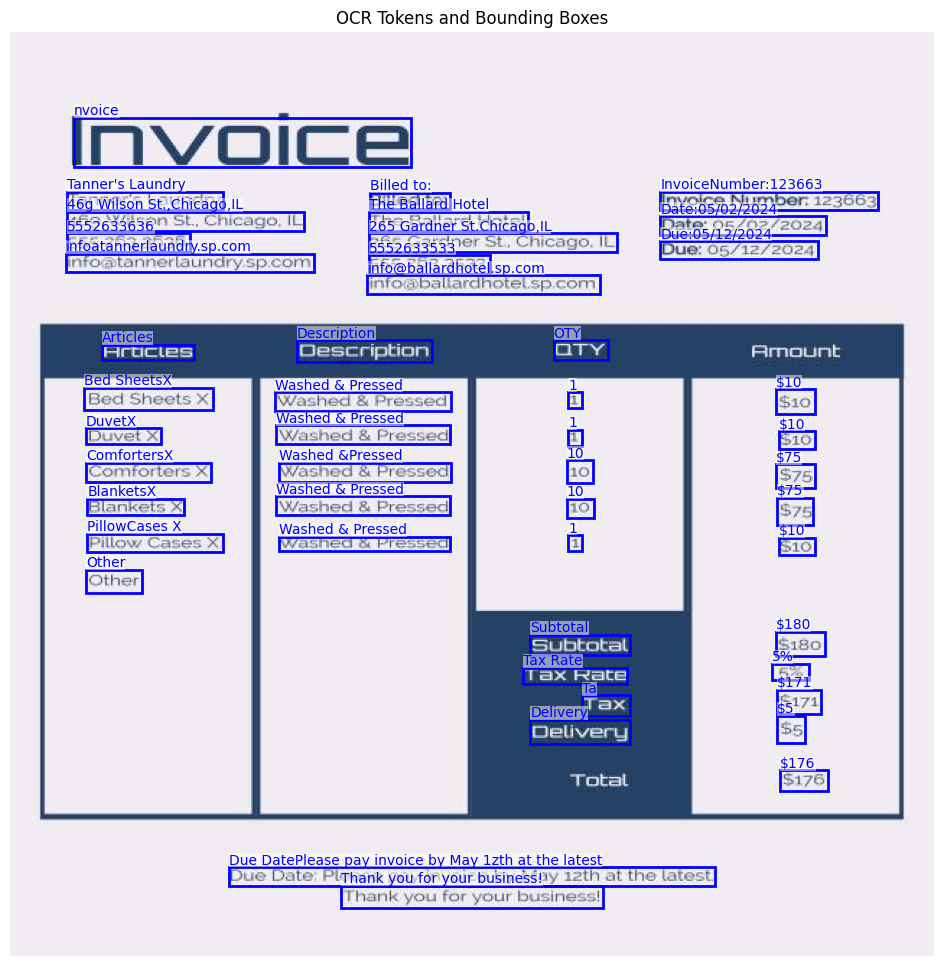

In [6]:
# 6. Visualize OCR Tokens on the Image
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(image)
for word, bbox in zip(ocr_words, ocr_bboxes):
    x0, y0, x2, y2 = bbox
    rect = patches.Rectangle((x0, y0), x2 - x0, y2 - y0, linewidth=2, edgecolor='blue', facecolor='none')
    ax.add_patch(rect)
    ax.text(x0, y0 - 2, word, fontsize=10, color='blue', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0))
plt.title("OCR Tokens and Bounding Boxes")
plt.axis('off')
plt.show()

## 7. Run Inference and Extract Predicted Labels
Feed the preprocessed inputs into the model, obtain predictions, and map predicted IDs to label names.

In [7]:
# 7. Run Inference and Extract Predicted Labels
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits.cpu().numpy()[0]
    pred_ids = np.argmax(logits, axis=-1)

# Get label list from model config
id2label = model.config.id2label if hasattr(model.config, 'id2label') else {i: str(i) for i in range(model.config.num_labels)}
pred_labels = [id2label[str(i)] if str(i) in id2label else id2label[i] for i in pred_ids]

# Only keep predictions for actual tokens (not padding)
actual_len = len(ocr_words)
pred_labels = pred_labels[:actual_len]
print(f"Predicted labels for {actual_len} tokens:")
for word, label in zip(ocr_words, pred_labels):
    print(f"{word:20s} -> {label}")

Predicted labels for 48 tokens:
nvoice               -> B-supplier_name
Tanner's Laundry     -> B-supplier_name
Billed to:           -> B-supplier_name
InvoiceNumber:123663 -> B-supplier_address
46g Wilson St.,Chicago,IL -> B-customer_name
The Ballard Hotel    -> B-customer_name
Date:05/02/2024      -> B-invoice_number
5552633636           -> B-customer_address
265 Gardner St.Chicago,IL -> B-customer_name
infoatannerlaundry.sp.com -> B-customer_address
Due:05/12/2024       -> B-invoice_date
5552633533           -> I-invoice_date
info@ballardhotel.sp.com -> B-customer_name
Articles             -> B-due_date
Description          -> O
OTY                  -> O
Bed SheetsX          -> O
Washed & Pressed     -> O
1                    -> O
$10                  -> O
DuvetX               -> B-item_description
Washed & Pressed     -> B-item_description
1                    -> O
$10                  -> O
ComfortersX          -> O
Washed &Pressed      -> B-item_description
10                   ->

## 8. Display Extracted Fields (Invoice Number, Date, Amount)
Parse the predicted labels to extract the values for invoice number, date, and amount, and display them in a list.

In [8]:
# 8. Display Extracted Fields (All Predicted Fields Except "O")

def extract_all_fields(tokens, labels):
    # Collect all unique field names (excluding "O")
    field_names = set()
    for label in labels:
        if label != "O" and label.startswith("B-"):
            field_names.add(label[2:])
    results = {}
    for field in field_names:
        # Extract contiguous tokens for each field (first occurrence)
        field_tokens = []
        capture = False
        for token, label in zip(tokens, labels):
            if label == f"B-{field}":
                if field_tokens:
                    break  # Only take the first occurrence
                field_tokens = [token]
                capture = True
            elif label == f"I-{field}" and capture:
                field_tokens.append(token)
            elif label.startswith("B-") and capture:
                break
            else:
                if capture:
                    break
        if field_tokens:
            results[field] = " ".join(field_tokens)
    return results

results = extract_all_fields(ocr_words, pred_labels)

print("\nExtracted Fields:")
if results:
    for k, v in results.items():
        print(f"{k}: {v}")
else:
    print("No fields extracted (other than 'O').")


Extracted Fields:
invoice_number: Date:05/02/2024
due_date: Articles
customer_address: 5552633636
item_description: DuvetX
invoice_date: Due:05/12/2024 5552633533
supplier_address: InvoiceNumber:123663
supplier_name: nvoice
item_total_price: 10
customer_name: 46g Wilson St.,Chicago,IL
tax_amount: Other
invoice_total: $10


## 9. Visualize Predicted Labels on the Image
Plot the image again, highlighting the tokens corresponding to the extracted fields (invoice number, date, amount) in different colors.

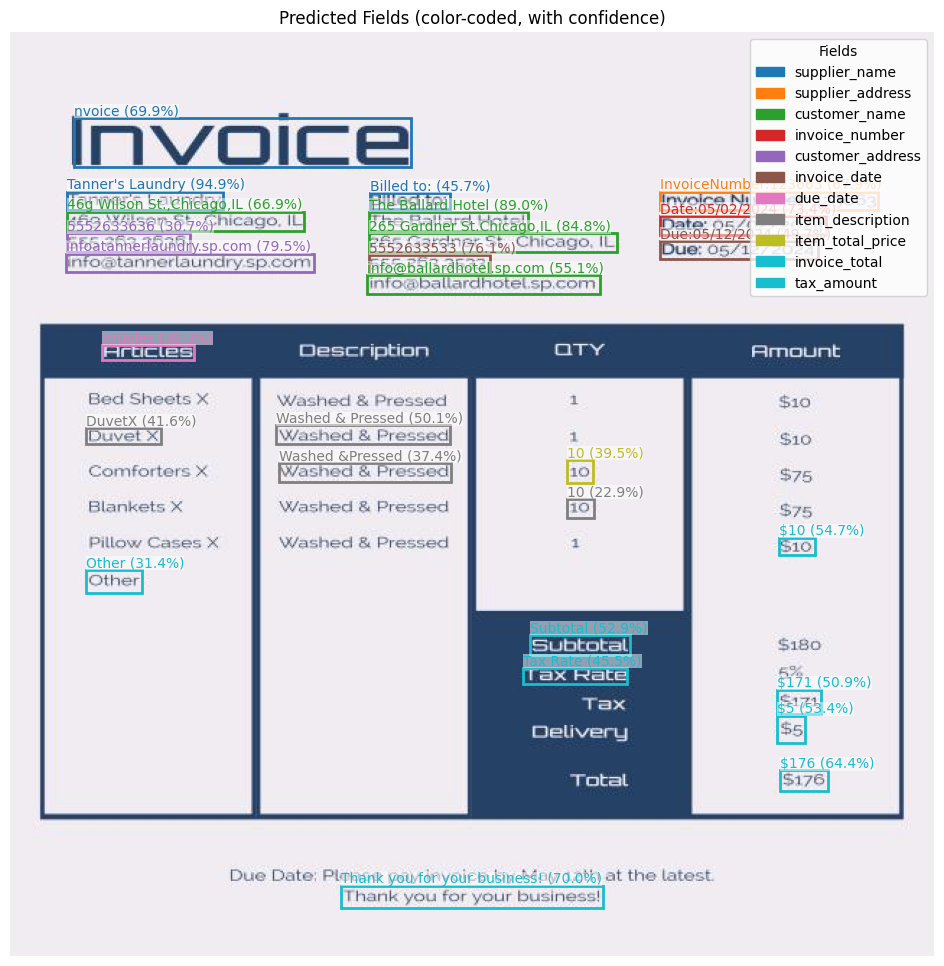

In [9]:
# 9. Visualize Predicted Labels on the Image (All Predicted Fields Except "O" with Confidence Scores)
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import torch.nn.functional as F

# Collect all unique field names (excluding "O")
field_names = []
for label in pred_labels:
    if label != "O" and label.startswith("B-"):
        field = label[2:]
        if field not in field_names:
            field_names.append(field)

# Assign colors from a colormap
cmap = cm.get_cmap('tab10', max(3, len(field_names)))
field_colors = {field: mcolors.to_hex(cmap(i)) for i, field in enumerate(field_names)}

# Compute confidence scores for each token's predicted label
probs = F.softmax(torch.tensor(logits), dim=-1).numpy()  # shape: (num_tokens, num_labels)
confidences = [probs[i, pred_id] for i, pred_id in enumerate(pred_ids)]

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(image)
for word, bbox, label, conf in zip(ocr_words, ocr_bboxes, pred_labels, confidences):
    if label != "O" and label.startswith(("B-", "I-")):
        field = label[2:]
        color = field_colors.get(field, "black")
        x0, y0, x2, y2 = bbox
        rect = patches.Rectangle((x0, y0), x2 - x0, y2 - y0, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(
            x0, y0 - 2,
            f"{word} ({conf*100:.1f}%)",
            fontsize=10, color=color,
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0)
        )
if field_colors:
    legend_patches = [patches.Patch(color=color, label=field) for field, color in field_colors.items()]
    ax.legend(handles=legend_patches, loc='upper right', title="Fields")
plt.title("Predicted Fields (color-coded, with confidence)")
plt.axis('off')
plt.show()